In [659]:
import numpy as np
import scipy.stats as st
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D, Flatten, Dense, Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.losses import mean_squared_error, categorical_crossentropy
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [658]:
import tensorflow as tf
sess = tf.Session()
K.set_session(sess)

In [170]:
def get_countnet(img_rows, img_cols, n_channels=3, n_classes=5):
    """ Regression network, output n_classes counts.
    :param img_rows: Height of the input image.
    :param img_cols: Width of the input image.
    :param n_channels: Number of channels in the input image (eg 3 for BGR)
    :param n_classes: Number of counts to output (eg 5, one for each type of sealion)
    """
    inputs = Input((img_rows, img_cols, n_channels))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)   # (h/2, w/2, 32)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)   # (h/4, w/4, 64)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)   # (h/8, w/8, 128)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)   # (h/16, w/16, 128)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)   # (h/16, w/16, 512)
    
    avg = AveragePooling2D((7, 7))(conv5)   #(h/(16 * 7), w/(16 * 7), 512)
    avg = Flatten()(avg)
    
    hidden = Dense(128, activation='relu')(avg)
    count_regression = Dense(n_classes)(hidden)
    
    model = Model(inputs=[inputs], outputs=[count_regression])
    model.compile(optimizer=Adam(lr=1e-5), loss=mean_squared_error, metrics=[mean_squared_error])

    return model

In [171]:
countNet = get_countnet(224, 224, 3, 5)

In [172]:
x = np.random.randn(2, 224, 224, 3)

In [173]:
y = countNet.predict(x, batch_size=2)

In [174]:
y

array([[-0.00106728, -0.02379322, -0.05574227, -0.01152828,  0.00355386],
       [-0.00060417, -0.02365067, -0.0562725 , -0.01130335,  0.0035546 ]], dtype=float32)

In [136]:
def get_unet(n_channels, n_classes):
    # Fully convolutional, we don't specify the image size
    inputs = Input((None, None, n_channels))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    #conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    #conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    #conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    #conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    #conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(n_classes, (1, 1), activation=None)(conv9)  # outputs N density map, one for each type of sealion

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss='mean_squared_error', metrics=['accuracy'])

    return model

In [687]:
def gkern(kernlen, nsig):
    """Returns a 2D Gaussian kernel array."""
    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel.astype(np.float32)

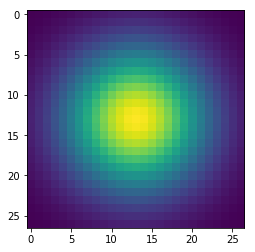

In [688]:
plt.imshow(gkern(27, 3))

In [689]:
def smooth_avg(x, ksize, sigma):
    """Apply the same gaussian kernel to each channel.
    :param x: 4-D tensor
    :param ksize: Width of the Gaussian kernel.
    :param sigma: "Inversed variance" of the Gaussian kernel.
    """
    n_classes = int(x.shape[-1])
    gaussian_kernel = gkern(ksize, sigma)  # shape (ksize, ksize)
    gaussian_kernel = np.repeat(gaussian_kernel[:, :, np.newaxis], n_classes, axis=2)  # shape (ksize, ksize, n_classes)
    gaussian_kernel = gaussian_kernel.reshape((ksize, ksize, n_classes, 1))
    gaussian_kernel = K.constant(value=gaussian_kernel, dtype=tf.float32)
    return tf.nn.depthwise_conv2d(x, gaussian_kernel, strides=[1, 1, 1, 1], padding='SAME')

In [792]:
SmoothLayer = Lambda(smooth_avg, arguments={"ksize": 27, "sigma": 1})

In [793]:
inputs = Input((224, 224, 3))
output = SmoothLayer(inputs)
model_smooth = Model(inputs=[inputs], outputs=[output])

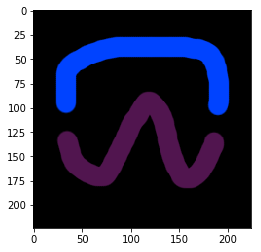

In [794]:
x = cv2.imread("../data/test_smooth.png")
x = x.reshape((1, 224, 224, 3))
plt.imshow(x[0])

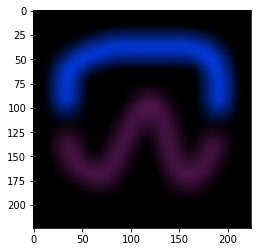

In [795]:
y = model_smooth.predict(x)
s = y[0].astype(np.uint8)
cv2.imwrite("../data/fff.png", s)
plt.imshow(s)

In [833]:
y_true = (cv2.imread("../data/test_smooth.png")/255.0).reshape((1, 224, 224, 3))

In [852]:
y_pred_rand = (cv2.imread("../data/test_smooth2.png")/255.0).reshape((1, 224, 224, 3))

In [853]:
y_pred_shifted = np.zeros((1, 224, 224, 3))
y_pred_shifted[0, 3:, 4:,:] = y_true[0, :-3, :-4,:]

In [854]:
noise = np.random.normal(0, 0.2, (1, 224, 224, 3))
y_pred_noisy = y_true + noise

In [855]:
def mse(y_true, y_pred):
    return np.mean(np.square(y_pred - y_true), axis=-1)

In [863]:
mse_rand = np.mean(mse(y_true, y_pred_rand))
mse_shifted = np.mean(mse(y_true, y_pred_shifted))
mse_noisy = np.mean(mse(y_true, y_pred_noisy))

In [864]:
y_true_sm = model_smooth.predict(y_true)

In [865]:
y_pred_shifted_sm = model_smooth.predict(y_pred_shifted)
mse_shifted_sm = np.mean(mse(y_true_sm, y_pred_shifted_sm))
y_pred_rand_sm = model_smooth.predict(y_pred_rand)
mse_rand_sm = np.mean(mse(y_true_sm, y_pred_rand_sm))
y_pred_noisy_sm = model_smooth.predict(y_pred_noisy)
mse_noisy_sm = np.mean(mse(y_true_sm, y_pred_noisy_sm))

In [866]:
print("Rand: ", mse_rand/mse_rand_sm)
print("Shifted: ", mse_shifted/mse_shifted_sm)
print("Noise: ", mse_noisy/mse_noisy_sm)

Rand:  2.12058035246
Shifted:  8.85030887181
Noise:  823.863538489


4.8657075e-05

In [851]:
def get_unet_smooth(n_channels, n_classes, gaussian_size, sigma):
    SmoothLayer = Lambda(smooth_avg, arguments={"ksize": gaussian_size, "sigma": sigma})
    
    # Fully convolutional, we don't specify the image size
    inputs = Input((None, None, n_channels))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    #conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    #conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    #conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    #conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    #conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(n_classes, (1, 1), activation=None)(conv9)  # outputs N density map, one for each type of sealion

    conv10_smooth = SmoothLayer(conv10)
    
    model = Model(inputs=[inputs], outputs=[conv10_smooth])

    model.compile(optimizer=Adam(lr=1e-5), loss='mean_squared_error', metrics=['accuracy'])

    return model

In [697]:
test = get_unet_smooth(3, 5, 27, 3)

In [698]:
x  = np.random.randn(1, 224, 224, 3)

In [699]:
y = test.predict(x, batch_size=1)

In [775]:
noise  = np.random.normal(loc=0, scale=0.2, size=(1, 224, 224, 3))

In [774]:
y = np.

array([[[[ 0.22383066,  0.39571372,  0.45308712],
         [-0.14326822,  0.06139457, -0.10076697],
         [-0.09848418,  0.06250268,  0.61472787],
         ..., 
         [-0.06357724, -0.17405397,  0.10338968],
         [-0.0160611 ,  0.1146495 , -0.10261768],
         [-0.24202778,  0.13669209, -0.30222504]],

        [[-0.13484586, -0.04985614, -0.36829545],
         [ 0.16630945,  0.04040881,  0.09013462],
         [ 0.02969454, -0.09993743,  0.16891056],
         ..., 
         [ 0.21780663, -0.50008935, -0.01394816],
         [-0.35490607, -0.24197502,  0.1069419 ],
         [ 0.14593879,  0.04677929,  0.10700241]],

        [[ 0.2062063 ,  0.10917462,  0.20124465],
         [-0.05712886, -0.23789453, -0.26301394],
         [ 0.17463572, -0.10373689,  0.08587297],
         ..., 
         [-0.4079429 , -0.55225609,  0.02602408],
         [ 0.21470373, -0.05464729, -0.12655936],
         [-0.24523014, -0.35270828, -0.35558011]],

        ..., 
        [[ 0.33880434, -0.09063689,

In [716]:
y

array([[[[ 0.01308148, -0.01200846, -0.02462627, -0.03678506, -0.00555139],
         [ 0.01476608, -0.01375009, -0.02772541, -0.04190183, -0.00621258],
         [ 0.01640456, -0.01540176, -0.03076441, -0.04702127, -0.0070128 ],
         ..., 
         [ 0.00982584, -0.0160932 , -0.02714087, -0.04874134, -0.00773515],
         [ 0.00858724, -0.01435301, -0.02425705, -0.04381122, -0.00667441],
         [ 0.00739431, -0.01256813, -0.02123459, -0.03871353, -0.00567721]],

        [[ 0.01480323, -0.01364705, -0.02753099, -0.04148619, -0.00630159],
         [ 0.01670693, -0.0156121 , -0.03097537, -0.04724607, -0.00707002],
         [ 0.01855393, -0.01747304, -0.03435504, -0.05300489, -0.00798698],
         ..., 
         [ 0.01132903, -0.01830265, -0.03050529, -0.0553561 , -0.00877379],
         [ 0.00992185, -0.01632693, -0.02726935, -0.04977268, -0.00756035],
         [ 0.00855851, -0.01430386, -0.02389077, -0.04400975, -0.00640669]],

        [[ 0.01654017, -0.01526468, -0.03021055, -0.04

In [700]:
y.shape

(1, 224, 224, 5)

Check mean_squared_error behavior

In [713]:
y_pred = np.zeros((1, 1, 2))
y_true = np.zeros((1, 1, 2))
y_pred[0,0,0] = 1.2
y_pred[0,0,1] = 0
y_true[0,0,0] = 1.0
y_true[0,0,1] = 0.5

In [714]:
f = mean_squared_error(y_pred, y_true)

In [715]:
with sess.as_default():
    print(f.eval())

[[ 0.145]]
